In [12]:
import pandas as pd
import numpy as np
import psycopg2
import decimal

from sqlalchemy import create_engine

import matplotlib.pyplot as plt

import seaborn as sns


# set plot size 
sns.set(rc={'figure.figsize':(18, 12)})

# show more rows
pd.set_option('display.max_rows', None)

In [13]:
# Environment
POSTGRES_ADDRESS = '192.168.1.61'
POSTGRES_PORT = '5433' 
POSTGRES_USERNAME = 'root' 
POSTGRES_PASSWORD = 'password' 
POSTGRES_DBNAME = 'pystock' 


# Thresholds above and below moving average considered significant
upper_pc_threshold = 0.04
lower_pc_threshold = 0.04

# ?
moving_average_days = 20
days_before_action = 4

# Price data to fetch
ticker = 'BP.L'
bench_ticker = 'ISF.L' #Blackrock FTSE 100 ETF
start_date = pd.to_datetime('2010-01-02').date()
end_date = pd.to_datetime('2021-12-30').date()

price_fetch_query = '''
SELECT
    t.price_date,
    t.ticker,
    t.close_price,
    f.ticker AS bench_ticker,
    f.close_price AS bench_close_price
FROM 
    inputs.prices t
INNER JOIN 
    inputs.prices f
ON t.price_date = f.price_date
WHERE 
    t.ticker = '{}' 
AND f.ticker = '{}'
AND t.price_date BETWEEN '{}' AND '{}';'''.format(ticker, bench_ticker, start_date, end_date)

print(price_fetch_query)



SELECT
    t.price_date,
    t.ticker,
    t.close_price,
    f.ticker AS bench_ticker,
    f.close_price AS bench_close_price
FROM 
    inputs.prices t
INNER JOIN 
    inputs.prices f
ON t.price_date = f.price_date
WHERE 
    t.ticker = 'BP.L' 
AND f.ticker = 'ISF.L'
AND t.price_date BETWEEN '2010-01-02' AND '2021-12-30';


In [14]:
# Create database connection
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=POSTGRES_USERNAME, 
                        password=POSTGRES_PASSWORD, 
                        ipaddress=POSTGRES_ADDRESS, 
                        port=POSTGRES_PORT, 
                        dbname=POSTGRES_DBNAME)) 
# Create the connection 
cnx = create_engine(postgres_str)

# Fetch price data
pg_prices=pd.read_sql_query(price_fetch_query, cnx)

# Sort and index price data
prices=pg_prices.sort_values(by=['price_date'])
prices = prices.set_index('price_date')


In [15]:

prices['volatility'] = prices['close_price'].rolling(window=10).min().shift(1) / prices['close_price'].rolling(window=10).max().shift(1)

prices['ma_days_before_action'] = prices['close_price'].rolling(window=days_before_action).max().shift(1)
prices['min_ma_days_before_action'] = prices['close_price'].rolling(window=days_before_action).min().shift(1)

prices['ma_upper'] = prices['close_price'].rolling(window=moving_average_days).mean().shift(1) * (1+upper_pc_threshold)
prices['ma_lower'] = prices['close_price'].rolling(window=moving_average_days).mean().shift(1) * (1-lower_pc_threshold)

#define state choices
state_choices = ['BELOW', 'ABOVE']


state_conditions = [prices['close_price'] < prices['ma_lower'], # Close price lower than lower ma boundary
                    prices['close_price'] > prices['ma_upper']] # Close price higher than upper ma boundary
    
prices['state'] =  np.select(state_conditions, state_choices, default='INSIDE')
    
# define recommend choices
recommend_choices = ['BUY', 'SELL']


#define conditions
recommend_conditions = [ # BUY
                        (prices['state'] == 'BELOW') &  # flagged as below AND
                        (prices['close_price'] > prices['ma_days_before_action']) &  # close pride above max for action period (ignore short term upticks) AND
                        (prices['volatility'] > 0.9), # market is not too volatile (<10% drop in action period) 
                            
                        #SELL
                        (prices['state'] == 'ABOVE') & 
                        (prices['close_price'] < prices['ma_days_before_action']) & 
                        (prices['close_price'] < prices['ma_days_before_action'])]

prices['recommend'] =  np.select(recommend_conditions, recommend_choices, default='HOLD')

prices['min_over_max'] = prices['min_ma_days_before_action'] / prices['ma_days_before_action']


sample_start_date = pd.to_datetime('2011-09-01').date()
sample_end_date = pd.to_datetime('2011-11-01').date()

prices.loc[sample_start_date:sample_end_date].head(4)


ticker  close_price bench_ticker  bench_close_price  volatility  \
price_date                                                                   
2011-09-01   BP.L       388.50        ISF.L             539.50    0.934867   
2011-09-02   BP.L       374.40        ISF.L             526.88    0.959374   
2011-09-05   BP.L       363.20        ISF.L             508.01    0.930302   
2011-09-06   BP.L       371.65        ISF.L             513.41    0.902472   

            ma_days_before_action  min_ma_days_before_action  ma_upper  \
price_date                                                               
2011-09-01                 402.45                      386.1  419.3488   
2011-09-02                 402.45                      386.3  417.0348   
2011-09-05                 402.45                      374.4  414.6376   
2011-09-06                 402.45                      363.2  412.1702   

            ma_lower   state recommend  min_over_max  
price_date                                            
2011-09-01  387.0912  INSIDE      HOLD      0.959374  
2011-09-02  384.9552   BELOW      HOLD      0.959871  
2011-09-05  382.7424   BELOW      HOLD      0.930302  
2011-09-06  380.4648   BELOW      HOLD      0.902472

In [16]:
prices_with_investments = prices.assign(change_cash_value=0,
                                       change_share_count=0,
                                       change_share_value=0,
                                       running_cash_value=0,
                                       running_share_count=0,
                                       running_share_value=0)

'''
prices_with_investments = prices
prices_with_investments["change_cash_value"] = 0
prices_with_investments["change_share_count"] = 0
prices_with_investments["change_share_value"] = 0
prices_with_investments["running_cash_value"] = 0
prices_with_investments["running_share_count"] = 0
prices_with_investments["running_share_value"] = 0
'''

prices_with_investments.head(2)

ticker  close_price bench_ticker  bench_close_price  volatility  \
price_date                                                                   
2010-01-04   BP.L        613.6        ISF.L             550.02         NaN   
2010-01-05   BP.L        620.1        ISF.L             552.23         NaN   

            ma_days_before_action  min_ma_days_before_action  ma_upper  \
price_date                                                               
2010-01-04                    NaN                        NaN       NaN   
2010-01-05                    NaN                        NaN       NaN   

            ma_lower   state recommend  min_over_max  change_cash_value  \
price_date                                                                
2010-01-04       NaN  INSIDE      HOLD           NaN                  0   
2010-01-05       NaN  INSIDE      HOLD           NaN                  0   

            change_share_count  change_share_value  running_cash_value  \
price_date                                                               
2010-01-04                   0                   0                   0   
2010-01-05                   0                   0                   0   

            running_share_count  running_share_value  
price_date                                            
2010-01-04                    0                    0  
2010-01-05                    0                    0

In [17]:
def buy_units( available_funds, unit_price ):
    "returns number of units to be bought and their cost"
    bought_units = available_funds // unit_price
    bought_unit_cost = bought_units * unit_price
    return bought_units, bought_unit_cost

a, b = buy_units(1000, 51)
print(a)
print(b)


19
969


In [18]:

test_limit = 10000
i=0
activity_series = []
account_activity = pd.DataFrame(activity_series,
                               columns=['price_date', 
                                        'ticker', 
                                        'close_price', 
                                        'close_price_pc', 
                                        'bench_close_price', 
                                        'bench_close_price_pc', 
                                        'ma_lower', 
                                        'ma_upper', 
                                        'recommend', 
                                        'max_ma_days_before_action',
                                        'min_ma_days_before_action',
                                        'change_cash_value',
                                        'change_share_count',
                                        'change_share_value',
                                        'running_cash_value',
                                        'running_share_count',
                                        'running_share_value',
                                        'running_account_value',
                                        'running_account_value_pc'])



recorded_running_cash_value = 10000
recorded_running_share_count = 0
recorded_running_share_value = 0
recorded_running_account_value = 0

for row_tuple in prices_with_investments.itertuples():
    if i>test_limit: break
    
    #  Initial values as base for percentages
    if i==0: 
            base_close_price = row_tuple.close_price
            base_bench_close_price = row_tuple.bench_close_price
            base_account_value = recorded_running_cash_value
    
    change_cash_value = 0
    change_share_count = 0 #minus sales plus purchases
    
    if row_tuple.recommend == 'BUY': 
        bought_units, bought_unit_cost = buy_units(recorded_running_cash_value,
                                                   row_tuple.close_price) # this is a rather arbitary price....
        change_share_count = bought_units
        change_cash_value -= bought_unit_cost
   
    if row_tuple.recommend == 'HOLD':
        change_share_value = (recorded_running_share_count * row_tuple.close_price) - recorded_running_share_value
        
    if row_tuple.recommend == 'SELL': 
        sold_units = recorded_running_share_count
        sold_value = recorded_running_share_count * row_tuple.close_price # this is a rather arbitary price....
        change_share_count -= sold_units
        change_cash_value += sold_value
        change_share_value = sold_value - recorded_running_share_value


    recorded_running_cash_value += change_cash_value
    recorded_running_share_count += change_share_count
    recorded_running_share_value = recorded_running_share_count * row_tuple.close_price
    recorded_running_account_value = recorded_running_cash_value + recorded_running_share_value
    
    
    account_activity.loc[len(account_activity.index)] = [row_tuple.Index, 
                                                          row_tuple.ticker, 
                                                          row_tuple.close_price, 
                                                          row_tuple.close_price / base_close_price, 
                                                          row_tuple.bench_close_price, 
                                                          row_tuple.bench_close_price / base_bench_close_price, 
                                                          row_tuple.ma_lower, 
                                                          row_tuple.ma_upper, 
                                                          row_tuple.recommend, 
                                                          row_tuple.ma_days_before_action,
                                                          row_tuple.min_ma_days_before_action,
                                                          change_cash_value, # change_cash_value
                                                          change_share_count, # change_share_count
                                                          change_share_value, # change_share_value
                                                          recorded_running_cash_value, # running_cash_value
                                                          recorded_running_share_count, # running_share_count
                                                          recorded_running_share_value, # running_share_value
                                                          recorded_running_account_value, # running_account_value
                                                          recorded_running_account_value / base_account_value] # running_account_value_percent
    
    i+=1    
    
    
account_activity = account_activity.set_index('price_date')
account_activity.head(1)
#account_activity.dtypes

ticker  close_price  close_price_pc  bench_close_price  \
price_date                                                          
2010-01-04   BP.L        613.6             1.0             550.02   

            bench_close_price_pc  ma_lower  ma_upper recommend  \
price_date                                                       
2010-01-04                   1.0       NaN       NaN      HOLD   

            max_ma_days_before_action  min_ma_days_before_action  \
price_date                                                         
2010-01-04                        NaN                        NaN   

            change_cash_value  change_share_count  change_share_value  \
price_date                                                              
2010-01-04                0.0                 0.0                 0.0   

            running_cash_value  running_share_count  running_share_value  \
price_date                                                                 
2010-01-04             10000.0                  0.0                  0.0   

            running_account_value  running_account_value_pc  
price_date                                                   
2010-01-04                10000.0                       1.0

In [8]:
## ADM bugger about with graphing. From: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

# Start and end of the date range to extract
# Plot daily and weekly resampled time series together
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#start_date = pd.to_datetime('2013-01-01').date()
#end_date = pd.to_datetime('2013-07-01').date()

#ax1.set_ylim([450,600])
#ax2.set_ylim([6000,12000])
ax1.plot(account_activity.loc[start_date:end_date, 'close_price'],
marker='.', linestyle='--', linewidth=0.5, label='Close', color='darkorange')
ax1.plot(account_activity.loc[start_date:end_date, 'ma_upper'],
marker='', linestyle='-', linewidth=1.3, label='20 week upper', color='red')
ax1.plot(account_activity.loc[start_date:end_date, 'ma_lower'],
marker='', linestyle='-', linewidth=1.3, label='20 week lower', color='green')

ax2.plot(account_activity.loc[start_date:end_date, 'running_cash_value'],
marker='.', linestyle='-', linewidth=0, label='running cash', color='silver')
ax2.plot(account_activity.loc[start_date:end_date, 'running_share_value'],
marker='.', linestyle='-', linewidth=0, label='running share', color='dimgray')
ax2.plot(account_activity.loc[start_date:end_date, 'running_account_value'],
marker='', linestyle='-', linewidth=1.3, label='running total', color='black')

ax1.set_ylabel('$')
ax2.set_ylabel('$')
ax1.legend();
ax2.legend();

In [9]:
account_activity.head()

ticker  close_price  close_price_pc  bench_close_price  \
price_date                                                          
2010-01-04   BP.L        613.6        1.000000             550.02   
2010-01-05   BP.L        620.1        1.010593             552.23   
2010-01-06   BP.L        619.4        1.009452             553.00   
2010-01-07   BP.L        623.3        1.015808             552.66   
2010-01-08   BP.L        621.7        1.013201             553.40   

            bench_close_price_pc  ma_lower  ma_upper recommend  \
price_date                                                       
2010-01-04              1.000000       NaN       NaN      HOLD   
2010-01-05              1.004018       NaN       NaN      HOLD   
2010-01-06              1.005418       NaN       NaN      HOLD   
2010-01-07              1.004800       NaN       NaN      HOLD   
2010-01-08              1.006145       NaN       NaN      HOLD   

            max_ma_days_before_action  min_ma_days_before_action  \
price_date                                                         
2010-01-04                        NaN                        NaN   
2010-01-05                        NaN                        NaN   
2010-01-06                        NaN                        NaN   
2010-01-07                        NaN                        NaN   
2010-01-08                      623.3                      613.6   

            change_cash_value  change_share_count  change_share_value  \
price_date                                                              
2010-01-04                0.0                 0.0                 0.0   
2010-01-05                0.0                 0.0                 0.0   
2010-01-06                0.0                 0.0                 0.0   
2010-01-07                0.0                 0.0                 0.0   
2010-01-08                0.0                 0.0                 0.0   

            running_cash_value  running_share_count  running_share_value  \
price_date                                                                 
2010-01-04             10000.0                  0.0                  0.0   
2010-01-05             10000.0                  0.0                  0.0   
2010-01-06             10000.0                  0.0                  0.0   
2010-01-07             10000.0                  0.0                  0.0   
2010-01-08             10000.0                  0.0                  0.0   

            running_account_value  running_account_value_pc  
price_date                                                   
2010-01-04                10000.0                       1.0  
2010-01-05                10000.0                       1.0  
2010-01-06                10000.0                       1.0  
2010-01-07                10000.0                       1.0  
2010-01-08                10000.0                       1.0

ticker  close_price  close_price_pc  ma_lower  ma_upper  \
price_date                                                           
2016-01-04   BP.L       347.55        1.000000  336.3984  364.4316   
2016-01-05   BP.L       348.15        1.001726  334.7448  362.6402   
2016-01-06   BP.L       343.45        0.988203  333.7656  361.5794   
2016-01-07   BP.L       337.70        0.971659  332.9856  360.7344   

            max_ma_days_before_action  min_ma_days_before_action  \
price_date                                                         
2016-01-04                     365.95                     354.00   
2016-01-05                     360.75                     347.55   
2016-01-06                     355.15                     347.55   
2016-01-07                     354.00                     343.45   

            close_price_pc  running_account_value  running_account_value_pc  \
price_date                                                                    
2016-01-04        1.000000                11571.7                       1.0   
2016-01-05        1.001726                11571.7                       1.0   
2016-01-06        0.988203                11571.7                       1.0   
2016-01-07        0.971659                11571.7                       1.0   

            max_ma_days_before_action_pc  min_ma_days_before_action_pc  \
price_date                                                               
2016-01-04                      1.000000                      1.000000   
2016-01-05                      0.985790                      0.981780   
2016-01-06                      0.970488                      0.981780   
2016-01-07                      0.967345                      0.970198   

            ma_lower_pc  ma_upper_pc  
price_date                            
2016-01-04     0.960000     1.040000  
2016-01-05     0.955281     1.034888  
2016-01-06     0.952487     1.031861  
2016-01-07     0.950261     1.029449

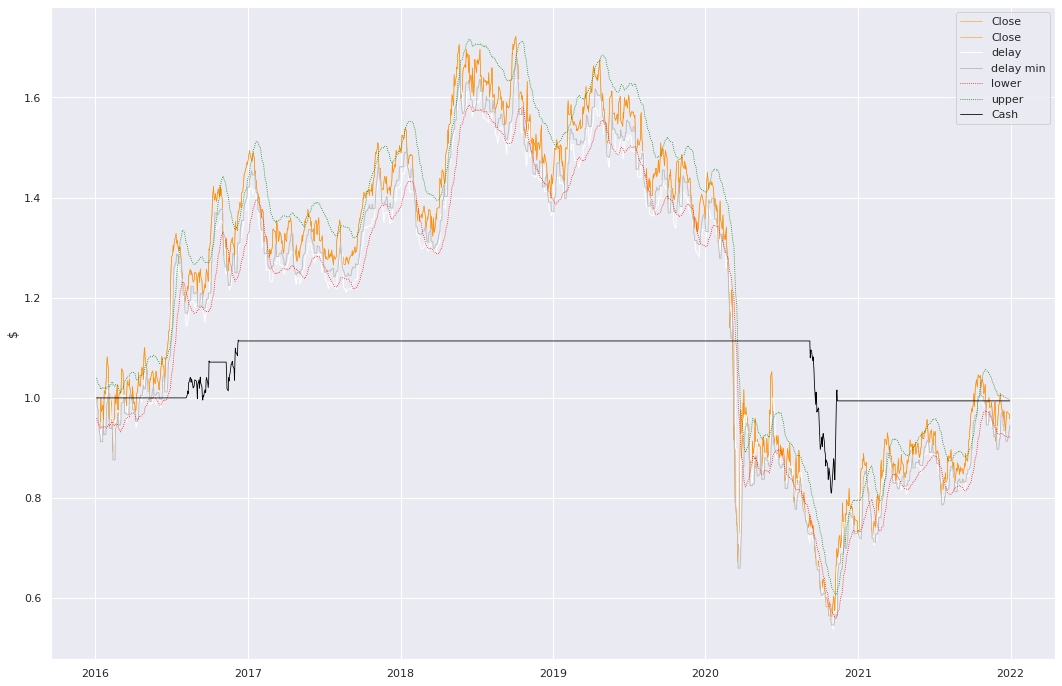

In [10]:
## ADM bugger about with graphing. From: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/


start_date = pd.to_datetime('2016-01-01').date()
end_date = pd.to_datetime('2026-12-01').date()

graph_activity = account_activity.loc[start_date:end_date][['ticker',
                                                            'close_price', 
                                                            'close_price_pc', 
                                                            'ma_lower', 
                                                            'ma_upper', 
                                                            'max_ma_days_before_action',
                                                            'min_ma_days_before_action',
                                                            'close_price_pc', 
                                                            'running_account_value', 
                                                            'running_account_value_pc']].copy(deep=True)

base_close_price = graph_activity.loc[graph_activity.index[0]].close_price
base_ma = graph_activity.loc[graph_activity.index[0]].ma_upper / (1 + upper_pc_threshold)
base_account_value = graph_activity.loc[graph_activity.index[0]].running_account_value
base_ma_days_before_action = graph_activity.loc[graph_activity.index[0]].max_ma_days_before_action
base_min_ma_days_before_action = graph_activity.loc[graph_activity.index[0]].min_ma_days_before_action

graph_activity['max_ma_days_before_action_pc'] = graph_activity['max_ma_days_before_action'] / base_ma_days_before_action
graph_activity['min_ma_days_before_action_pc'] = graph_activity['min_ma_days_before_action'] / base_min_ma_days_before_action
graph_activity['close_price_pc'] = graph_activity['close_price'] / base_close_price
graph_activity['ma_lower_pc'] = graph_activity['ma_lower'] / base_ma
graph_activity['ma_upper_pc'] = graph_activity['ma_upper'] / base_ma
graph_activity['running_account_value_pc'] = graph_activity['running_account_value'] / base_account_value

# Start and end of the date range to extract
# Plot daily and weekly resampled time series together
fig, ax1 = plt.subplots()
ax1.plot(graph_activity.loc[start_date:end_date, 'close_price_pc'],
marker='', linestyle='-', linewidth=0.5, label='Close', color='darkorange')
ax1.plot(graph_activity.loc[start_date:end_date, 'max_ma_days_before_action_pc'],
marker='', linestyle='-', linewidth=1, label='delay', color='white')
ax1.plot(graph_activity.loc[start_date:end_date, 'min_ma_days_before_action_pc'],
marker='', linestyle='-', linewidth=1, label='delay min', color='silver')
ax1.plot(graph_activity.loc[start_date:end_date, 'ma_lower_pc'],
marker='', linestyle=':', linewidth=0.8, label='lower', color='red')
ax1.plot(graph_activity.loc[start_date:end_date, 'ma_upper_pc'],
marker='', linestyle=':', linewidth=0.8, label='upper', color='green')
ax1.plot(graph_activity.loc[start_date:end_date, 'running_account_value_pc'],
marker='', linestyle='-', linewidth=0.8, label='Cash', color='black')

ax1.set_ylabel('$')
ax1.legend();
pd.set_option('display.max_rows', None)
graph_activity.head(4)


In [11]:
# Start and end of the date range to extract
# Plot daily and weekly resampled time series together
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot(graph_activity.loc[start_date:end_date, 'close_price'],
marker='', linestyle='-', linewidth=0.5, label='Close', color='darkorange')
ax1.plot(graph_activity.loc[start_date:end_date, 'max_ma_days_before_action'],
marker='', linestyle='-', linewidth=1, label='delay', color='white')
ax1.plot(graph_activity.loc[start_date:end_date, 'min_ma_days_before_action'],
marker='', linestyle='-', linewidth=1, label='delay min', color='silver')
ax1.plot(graph_activity.loc[start_date:end_date, 'ma_lower'],
marker='', linestyle=':', linewidth=0.8, label='lower', color='red')
ax1.plot(graph_activity.loc[start_date:end_date, 'ma_upper'],
marker='', linestyle=':', linewidth=0.8, label='upper', color='green')
ax2.plot(graph_activity.loc[start_date:end_date, 'running_account_value'],
marker='', linestyle='-', linewidth=0.8, label='Cash', color='black')

ax1.set_ylabel('$')
ax1.legend();

